In [1]:
import numpy as np
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import v2 as T
import matplotlib.pyplot as plt
import random


In [2]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print(device)

cpu


# **LOAD DATASET**

In [3]:
path = "/kaggle/input/ai-generated-images-vs-real-images"
class MyDataset(Dataset):
    def __init__(self):
        ai_path = "/kaggle/input/ai-generated-images-vs-real-images/AiArtData/AiArtData/*"
        real_path = "/kaggle/input/ai-generated-images-vs-real-images/RealArt/RealArt/*"
        self.data = []
        for pic in glob.glob(real_path):
            self.data.append([pic,  0])
        for pic in glob.glob(ai_path):
            self.data.append([pic, 1])
        
    def __len__(self):
        return len(self.data)
        
        
    def __getitem__(self, index):
        image, target = read_image(self.data[index][0]), self.data[index][1]
        t = T.Compose([
            T.Resize((300, 300), antialias=True),
            T.Lambda(lambda x : x.repeat(3,1,1) if x.size(0) == 1 else x),
            T.Lambda(lambda x : x[:3,:, :] if x.size(0) == 4 else x),
            T.ToDtype(torch.float, scale=True),
            T.ToPureTensor()])
        image, target = t(image), target
        return image, target

In [4]:
batch_size = 3
data = MyDataset()

In [5]:
indices = [i for i in range(len(data))]
train_data = torch.utils.data.Subset(data, indices[:-100])
test_data = torch.utils.data.Subset(data, indices[-100:])
load_train = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True)
load_test = DataLoader(test_data, batch_size=1, shuffle=True)

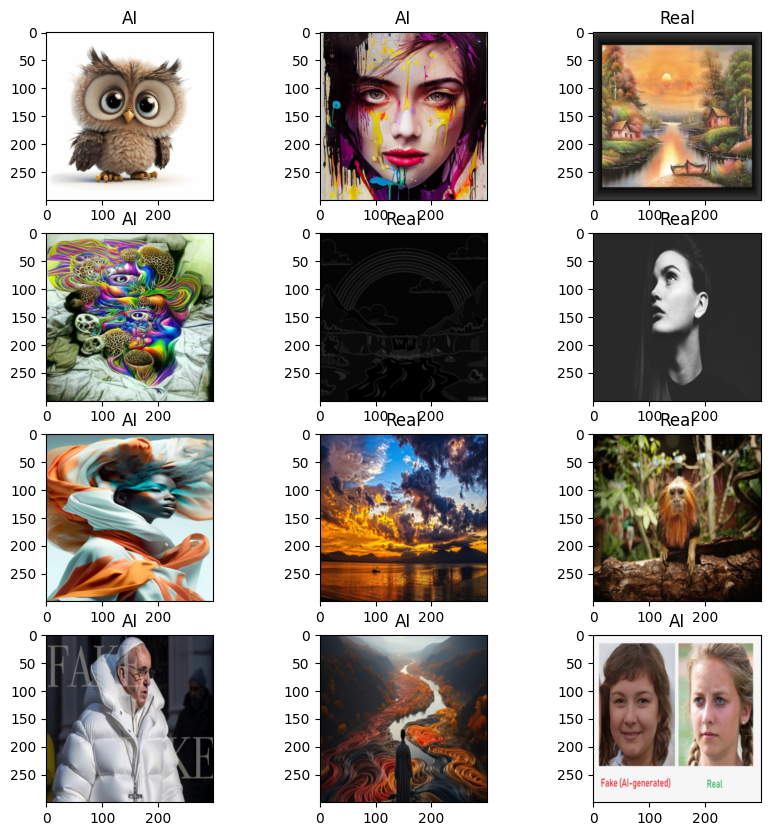

In [6]:

fig, axs = plt.subplots(4, batch_size, figsize=(10, 10))
row = 0
for images, targets in load_train:
    for j in range(batch_size):
        axs[row][j].imshow(images[j].permute(1,2,0))
        axs[row][j].set_title("Real" if targets[j] == 0 else "AI")

    row += 1
    if row == 4:
        break

In [7]:
from torch import nn
import torch.nn.functional as F

# **BUILD NN MODEL USING PYTORCH**

In [8]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 3)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.ada_pool = nn.AdaptiveAvgPool2d((10, 10))
        self.fc1 = nn.LazyLinear(100)
        self.fc2 = nn.Linear(100, 10)
        self.fc3 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.ada_pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

In [9]:
my_net = NN()
print(my_net)

NN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ada_pool): AdaptiveAvgPool2d(output_size=(10, 10))
  (fc1): LazyLinear(in_features=0, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
)


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# **VGG16 and RESNET18 model**

In [10]:
import torchvision

def vgg16_model():
    my_vgg16 = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
    for params in my_vgg16.parameters():
        params.requires_grad = False
    in_features = my_vgg16.classifier[6].in_features

    my_vgg16.classifier[6] = nn.Sequential(
    nn.Linear(in_features, 100),
    nn.ReLU(),
    nn.Dropout(p = 0.2),
    nn.Linear(100, 2),
    nn.Softmax(dim=1))
    return my_vgg16

def resnet18_model():
    my_resnet18 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
    for params in my_resnet18.parameters():
        params.requires_grad = False
    
    in_features = my_resnet18.fc.in_features
    my_resnet18.fc = nn.Sequential(
    nn.Linear(in_features, 100),
        nn.ReLU(),
    nn.Dropout(p = 0.2),
    nn.Linear(100, 2),
    nn.Softmax(dim=1))
    
    return my_resnet18


In [11]:
print("RESNET model: ", resnet18_model())
print("VGG model: ", vgg16_model())

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 74.2MB/s]


RESNET model:  ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(i

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 142MB/s] 


VGG model:  VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0

In [12]:
model = vgg16_model()
# model = resnet18_model()

model.to(device)

for img,targets in load_train:
    img, target = img.to(device), targets.to(device)
    print(img.size())
    pred=model(img)
    print(pred)
    print(targets)
    break
    
for img,targets in load_test:
    img, target = img.to(device), targets.to(device)
    print(img.size())
    pred=model(img)
    print(pred[0][0].item())
    break
    


torch.Size([3, 3, 300, 300])
tensor([[0.5753, 0.4247],
        [0.6477, 0.3523],
        [0.5620, 0.4380]], grad_fn=<SoftmaxBackward0>)
tensor([0, 1, 1])
torch.Size([1, 3, 300, 300])
0.5736871361732483


In [13]:
import torch.optim as optim
model = vgg16_model()
model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

def train_model(model, loss_func, optimizer):
    i=0;
    total_loss = 0;
    model.train()
    for img,targets in load_train:
        img,targets = img.to(device), targets.to(device)
        optimizer.zero_grad()
        pred = model(img)
        loss = loss_func(pred, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if i % 100 == 0:
            print(loss.item())
        i += 1
    return float(total_loss) / float(i)

In [15]:

best_accuracy = 0
def test_model(model, loss_func):
    i = 0
    total_loss = 0    
    TP, TN, FP, FN = 0, 0, 0, 0
    for img, targets in load_test:
        img, targets = img.to(device), targets.to(device)
        model.eval()
        with torch.no_grad():
            pred = model(img)
            loss = loss_func(pred, targets)
            total_loss += loss.item()
            if targets[0].item() == 1:
                if pred[0][1].item() > 0.5:
                    TP += 1
                else:
                    FN += 1
            else:
                if pred[0][1].item() > 0.5:
                    FP += 1
                else:
                    TN += 1
        i += 1
    total = TP + TN + FP + FN
    print("--------- evaluation -------")
    print("Number of images in test = ", total)
    print("Loss = ", loss)
    print("TP, TN, FP, FN = ", TP, TN, FP, FN)
    print("Precision = ", float(TP) / float(TP + FP))
#     print("Recall = ", float(TP) / float(TP + FN))
    accuracy = float(TP + TN) / float(total)
    best_accuracy = max(accuracy, best_accuracy)
    print("Accuracy = ", float(TP + TN) / float(total))
    print("---------------------------")
    return float(total_loss) / float(i)

In [ ]:
train_loss = []
test_loss =[]
epoch = 10

print("start: ")
for e in range(epoch):
    print("EPOCH: ", e)
    print("\n")
    
    train_l = train_model(model, loss_func, optimizer) 
    test_l = test_model(model, loss_func)
    train_loss.append(train_l)
    test_loss.append(test_l)
    
fig,ax = plt.subplots(1,1)
ax.plot([i for i in range(epoch)], train_loss)
ax.plot([i for i in range(epoch)], test_loss)

start: 
EPOCH:  0


0.6967284083366394
0.4803495407104492


libpng warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


0.5057129263877869
